<a href="https://colab.research.google.com/github/clawrencia/COMP90042_Project/blob/main/NLP_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TASK 1: Rumour Classification of Twitter Data

In [ ]:
!pip install torch torchvision transformers
!pip install tweet-preprocessor
!pip install nltk

     |████████████████████████████████| 2.3MB 11.1MB/s 
     |████████████████████████████████| 3.3MB 37.5MB/s 
     |████████████████████████████████| 901kB 34.8MB/s 


In [ ]:
import nltk
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
#Mount to GDrive Files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load the json files
import json
import pandas as pd
import torch


file_train_x = '/content/drive/MyDrive/Data/train.data.jsonl'
file_train_y = '/content/drive/MyDrive/Data/train.label.json'
file_dev_x = '/content/drive/MyDrive/Data/dev.data.jsonl'
file_dev_y = '/content/drive/MyDrive/Data/dev.label.json'
file_test_x = '/content/drive/MyDrive/Data/test.data.jsonl'



In [ ]:
#Loading x_data as df

def load_feat_df(file_path):
  line_list = []
  with open(file_path) as f:
      for line in f:
          a_dict = json.loads(line)
          df = pd.DataFrame(a_dict)
          line_list.append(df)

  df = pd.concat(line_list)
  df = df.loc[:,['id_str','in_reply_to_status_id_str','text']]

  return df

x_dev_df = load_feat_df(file_dev_x)
x_train_df = load_feat_df(file_train_x)
x_test_df = load_feat_df(file_test_x)

In [ ]:
#Loading labels as df
def load_label_df(file_path):
 
  with open(file_path) as f:
    a_dict = json.load(f)
  df =pd.DataFrame.from_dict(a_dict, orient='index')
  return df

y_dev_df = load_label_df(file_dev_y)
y_train_df = load_label_df(file_train_y)


In [ ]:
# A lemmatizer function 

from nltk.corpus import wordnet

lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
words = set(nltk.corpus.words.words()) #a list of words provided by NLTK
words = set([ word.lower() for word in words ]) #lowercase all the words for better matching

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = lemmatizer.lemmatize(word,'n')
    return lemma

In [ ]:
#Preprocessing and Cleaning Up Data
import preprocessor as p 
import string 

#A function to clean text
def clean_text(dirty_text):
  #remove non-ascii words and characters
  encoded_string = dirty_text.encode("ascii", "ignore")
  text = encoded_string.decode()

  #remove &, < and >
  text = text.replace(r'&amp;',r'and')
  text = text.replace(r'&lt;',r'<')
  text = text.replace(r'&gt;',r'>')
  
  #remove punctuation
  punctuation_list = string.punctuation.replace("#", "")
  text = text.translate(str.maketrans('', '', punctuation_list))

  #Lowercase and strip blankspace from both ends
  text = text.lower()
  text = text.strip()

  return text


In [ ]:
# Max Match Function for Hashtags 
import re

def max_match_hashtags(dataset):
  cleaned_tweet=[]
  p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.SMILEY,p.OPT.MENTION)
  for tweet in dataset['text']:
    tweet = p.clean(str(tweet))
    tweet = clean_text(tweet)
    for word in tweet.split():
        if word.startswith('#'):
          hashtag = word
          tokens=[]
          index =0
          
          while index <len(hashtag):
            maxWord=hashtag[index]
              
              #looping over the letters in a word, and finding the longest word        
            for j in range(index,len(hashtag)):
              temp = hashtag[index:j+1]
              
              #find the lemmatized word in the corpus, and assign it as a maxWord if found
              if lemmatize(temp) in words and len(temp)>len(maxWord):
                  maxWord = temp
              else:
                  continue
                  
            #Changing the index with respect to the maximum word found
            index=index+len(maxWord)
            tokens.append(maxWord)
          tokens = ' '.join(tokens[1:])
          tweet = tweet.replace(word,tokens)
    cleaned_tweet.append(tweet)
 
  dataset['text_']= cleaned_tweet
  return dataset

x_dev_df_clean = max_match_hashtags(x_dev_df)
x_train_df_clean = max_match_hashtags(x_train_df)
x_test_df_clean = max_match_hashtags(x_test_df)

In [ ]:
# Function to concate reply tweets for train and dev data
import preprocessor as p 
import numpy as np
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
def combine_tweets(x_dataset,y_dataset,le):
  label = y_dataset[0]
  label = le.fit_transform(label)

  main_tweet_df = pd.DataFrame(columns=['id_str','text'])

  for index,row in x_dataset.iterrows():
  
    if row['in_reply_to_status_id_str']==None:
      main_tweet= {'id_str':row['id_str'], 'text': row['text_']}
      main_tweet_df = main_tweet_df.append(main_tweet,ignore_index=True)
      x_dataset.drop(index)

  replies_x =x_dataset.groupby(x_dataset['in_reply_to_status_id_str'],sort=False)['text_'].apply(' '.join).reset_index()
  replies_x.columns =['id_str','reply_text']

  df = main_tweet_df.merge(replies_x, on='id_str',how='left')
  df['label'] = np.array(label)
  df['reply_text'] = df['reply_text'].fillna('None')
  df['combined'] = (df['text'].map(str) +' '+df['reply_text'].map(str)).apply(lambda row:row.strip())
  return df

x_dev_combined_df = combine_tweets(x_dev_df_clean,y_dev_df,le)
x_train_combined_df = combine_tweets(x_train_df_clean,y_train_df,le)

#Uncomment for No Preprocessing
#x_dev_combined_df = combine_tweets(x_dev_df,y_dev_df,le) #no preprocessing
#x_train_combined_df = combine_tweets(x_train_df,y_train_df,le) #no preprocessing

In [ ]:
# Function to concate reply tweets for test and COVID-19 data
import preprocessor as p 
import numpy as np

def combine_tweets_test(x_dataset):

  main_tweet_df = pd.DataFrame(columns=['id_str','text'])

  for index,row in x_dataset.iterrows():
  
    if row['in_reply_to_status_id_str']==None:
      main_tweet= {'id_str':row['id_str'], 'text': row['text_']}
      main_tweet_df = main_tweet_df.append(main_tweet,ignore_index=True)
      x_dataset.drop(index)

  replies_x =x_dataset.groupby(x_dataset['in_reply_to_status_id_str'],sort=False)['text_'].apply(' '.join).reset_index()
  replies_x.columns =['id_str','reply_text']

  df = main_tweet_df.merge(replies_x, on='id_str',how='left')
 
  df['reply_text'] = df['reply_text'].fillna('None')
  df['combined'] = (df['text'].map(str) +' '+df['reply_text'].map(str)).apply(lambda row:row.strip())
  return df

x_test_combined_df = combine_tweets_test(x_test_df_clean)

#Uncomment this for no preprocessing 
# x_test_combined_df = combine_tweets_test(x_test_df) #no preprocessing

In [ ]:
#Check shape
x_train_combined_df.shape
x_test_combined_df.shape
x_dev_combined_df.shape

(580, 5)

In [ ]:
#Check stats of data

def get_stats(data):
  rumour_count = 0
  non_rumour_count = 0
  data_count = 0

  for index, row in data.iterrows():
      data_count += 1
      if row['label'] == 1:
        rumour_count += 1
      elif row['label'] == 0:
        non_rumour_count += 1
  print('Data Size: '+str(data_count))
  print('Rumour: '+str(rumour_count))
  print('Non-Rumour: '+str(non_rumour_count))

get_stats(x_dev_combined_df)
get_stats(x_test_combined_df)
get_stats(x_train_combined_df)

Data Size: 4641
Rumour: 1583
Non-Rumour: 3058


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


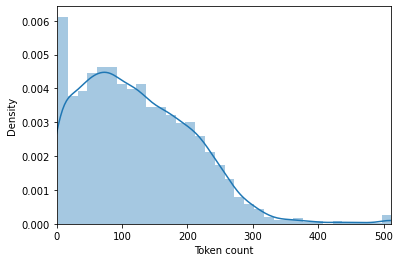

In [ ]:
# A function to check the max length of the token with respect to BERT BASE 
from transformers import BertTokenizer
import seaborn as sns
import matplotlib.pyplot as plt

def check_max_length(x_dataset):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  token_lens = []
  token_lens_reply=[]
  max_len=0
  for txt in x_dataset['reply_text']:
    input_ids = tokenizer.encode(str(txt),max_length=512)
    token_lens.append(len(input_ids))
  
  sns.distplot(token_lens)
  plt.xlim([0,512]);
  plt.xlabel('Token count');
 
#Check the max token by using the train dataset which is the bigger dataset)
#The tokenization is done on 'reply_text' data which is a coombination of all the
#replies within a tweet. 

check_max_length(x_train_combined_df) #value of 512 for train

In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, AutoTokenizer
import pandas as pd

#A Class that creates a a tokenized IDS and attention mask values with respect to BERT BASE 
#This class is for train and dev data only
class DatasetTokenizer(Dataset):

  def __init__(self,dataset,max_len):
    self.dataset=dataset
    self.max_len= max_len
    self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self,index):
    main_text = str(self.dataset.loc[index,'text'])
    reply_text = str(self.dataset.loc[index,'reply_text'])
    labels = self.dataset.loc[index,'label']

    encoding = self.tokenizer(main_text,
                              #reply_text, ##Comment this when testing for main_text only
                              padding='max_length',
                              truncation=True,
                              max_length=self.max_len,
                              return_tensors='pt')
    
    tokens_ids_tensor = encoding['input_ids'].squeeze(0)
    attention_mask = encoding['attention_mask'].squeeze(0)

    return tokens_ids_tensor, attention_mask,labels
  

In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, AutoTokenizer
import pandas as pd

#A Class that creates a tokenized IDS and attention mask values with respect to BERT BASE 
#This class is for test and COVID-19 data only
class DatasetTokenizerTest(Dataset):

  def __init__(self,dataset,max_len):
    self.dataset=dataset
    self.max_len= max_len
    self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self,index):
    main_text = str(self.dataset.loc[index,'text'])
    reply_text = str(self.dataset.loc[index,'reply_text'])
    combined_text = str(self.dataset.loc[index,'combined'])
    encoding = self.tokenizer(main_text,
                              #reply_text, ##Comment this when testing for main text only
                              padding='max_length',
                              truncation=True,
                              max_length=self.max_len,
                              return_tensors='pt')
    
    tokens_ids_tensor = encoding['input_ids'].squeeze(0)
    attention_mask = encoding['attention_mask'].squeeze(0)
  
  
    return tokens_ids_tensor, attention_mask

In [ ]:
dev_tokenized = DatasetTokenizer(x_dev_combined_df,max_len=512)
train_tokenized = DatasetTokenizer(x_train_combined_df,max_len=512)
test_tokenized = DatasetTokenizerTest(x_test_combined_df, max_len=512)


In [ ]:
#Converting into Data Loaders using torch
#Batch size 16 
#Attempted batch size 32, but not enough resources
from torch.utils.data import DataLoader

dev_loader = DataLoader(dev_tokenized, batch_size=16, num_workers=5)
train_loader = DataLoader(train_tokenized, batch_size=16, num_workers=5)
test_loader = DataLoader(test_tokenized, batch_size=16, num_workers=5)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel


class RumourClassifier(nn.Module):
  def __init__(self):
    super(RumourClassifier, self).__init__()
  
    self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
    
    #Classification layer
    #input dimension is 768 because BERT-BASE's hidden layer is 768
    #output dimension is 1 because this is binary classification
    self.cls_layer = nn.Linear(768, 1)


  def forward(self, seq, attn_masks):
   
    #Feeding the input to BERT model to get contextualized representations
    outputs = self.bert_layer(seq, attention_mask = attn_masks)
    cont_reps = outputs.last_hidden_state

    #Obtaining the representation the first token which is [CLS]
    cls_rep = cont_reps[:, 0]

    #Feeding cls_rep to the classifier layer
    logits = self.cls_layer(cls_rep)

    return logits

In [ ]:
gpu = 0 #gpu ID
print("Creating the rumour classifier, initialised with pretrained BERT-BASE parameters...")
net = RumourClassifier()
net.cuda(gpu) #Enable gpu support for the model
print("Done creating the rumour classifier.")

Creating the rumour classifier, initialised with pretrained BERT-BASE parameters...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Done creating the rumour classifier.


In [ ]:
import torch.nn as nn
import torch.optim as optim

#Intialized the optimizer using ADAM
opti = optim.Adam(net.parameters(), lr = 2e-5)

In [ ]:
import time

def train(net, opti, train_loader, dev_loader, max_eps, gpu):

    best_acc = 0
    criterion = nn.BCEWithLogitsLoss()
    st = time.time()
    for ep in range(max_eps):
        
        for it, input_vals in enumerate(train_loader):
            #Clear gradients
            opti.zero_grad()  
            #Converting to cuda tensors
            seq, attn_masks, labels = input_vals[0].cuda(gpu), input_vals[1].cuda(gpu), input_vals[2].cuda(gpu)

            #Get logits
            logits = net(seq, attn_masks)

            #Compute loss
            loss = criterion(logits.squeeze(-1), labels.float())

            #Backprop gradients
            loss.backward()

            #Optimization step
            opti.step()
              
            if it % 100 == 0:
                #Obtain probability and use softmax function
                probs = torch.sigmoid(logits.unsqueeze(-1))
                softmax_probs = (probs > 0.5).long()
                acc = (softmax_probs.squeeze()==labels).float().mean()
                print("Iteration {} of epoch {} complete. Loss: {}; Accuracy: {}; Time taken (s): {}".format(it, ep+1, loss.item(), acc, (time.time()-st)))
                st = time.time()

        
        dev_acc, dev_loss = evaluate(net, criterion, dev_loader, gpu)
        print("Epoch {} complete! Development Accuracy: {}; Development Loss: {}".format(ep+1, dev_acc, dev_loss))
        #Save the best weights
        if dev_acc > best_acc:
            print("Best development accuracy improved from {} to {}, saving model...".format(best_acc, dev_acc))
            best_acc = dev_acc
            torch.save(net.state_dict(), 'sstcls_{}.dat'.format(ep))

In [ ]:
def evaluate(net, criterion, dataloader, gpu):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        for input_data in dataloader:
            #Converting to cuda tensors
            seq, attn_masks, labels = input_data[0].cuda(gpu), input_data[1].cuda(gpu), input_data[2].cuda(gpu)
            #get logits
            logits = net(seq, attn_masks)
            
            #Obtain probability and use softmax function
            probs = torch.sigmoid(logits.unsqueeze(-1))
            softmax_probs = (probs > 0.5).long()
            acc = (softmax_probs.squeeze() == labels).float().mean()

            #Calculate mean loss and mean accuracy
            mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            mean_acc += acc
            count += 1

    return mean_acc / count, mean_loss / count

In [ ]:
num_epoch =2

#fine-tune the model
train(net, opti, train_loader, dev_loader, num_epoch, gpu)

In [ ]:
#Function to get the prediction for testing / COVID-19 file
def get_preds(net, dataloader):
  net = net.eval()

  predictions =[]
  prediction_probs=[]

  with torch.no_grad():
    for seq, attn_masks in dataloader:
      #Converting to cuda tensors
      seq, attn_masks= seq.cuda(gpu), attn_masks.cuda(gpu)

      #Get logits value 
      logits = net(seq=seq,attn_masks = attn_masks)
      _, preds = torch.max(logits,dim=1)

      #Get probability and use softmax function 
      probs = torch.sigmoid(logits.unsqueeze(-1))
      soft_probs = (probs > 0.5).long()

      predictions.extend(preds)
      prediction_probs.extend(soft_probs)

  predictions = torch.stack(predictions).cpu()
  prediction_probs=torch.stack(prediction_probs).cpu()

  return predictions, prediction_probs

In [ ]:

#Function to get the prediction for dev data
def get_preds_dev(net, dataloader):
  net = net.eval()

  predictions =[]
  prediction_probs=[]

  with torch.no_grad():
    for seq, attn_masks,labels in dataloader:
      #Converting to cuda tensors
      seq, attn_masks= seq.cuda(gpu), attn_masks.cuda(gpu)

      #Get logits value 
      logits= net(seq=seq,attn_masks = attn_masks)
      _, preds = torch.max(logits,dim=1)

      #Get probability and use softmax function 
      probs = torch.sigmoid(logits.unsqueeze(-1))
      soft_probs = (probs > 0.5).long()

      predictions.extend(preds)
      prediction_probs.extend(soft_probs)

  predictions = torch.stack(predictions).cpu()
  prediction_probs=torch.stack(prediction_probs).cpu()

  return predictions, prediction_probs

In [ ]:
y_pred, y_pred_probs = get_preds(net,test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
dev_pred, dev_pred_probs = get_preds_dev(net, dev_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#Detach the prediction from the cpu 
def detach_val(pred_probs):
  detach = pred_probs.detach().cpu().numpy()
  result = [] 
  for i in detach:
    for j in i[0]:
      result.append(j)
  return result

y_res = detach_val(y_pred_probs)
dev_res = detach_val(dev_pred_probs)

In [ ]:
#A function to merge the test data predictions to their respective IDs and 
# download as json file
def merge_data(data,pred,le):
  y_data= data['id_str']
  y_labels = le.inverse_transform(pred)
  y_labels = pd.DataFrame(y_labels)

  result = pd.concat([y_data,y_labels],axis=1)
  json_format = result.set_index('id_str').to_dict()
  
  with open('test-output.json','w') as f:
      json.dump(json_format[0],f)

merge_data(x_test_combined_df,y_res,le)

In [ ]:
#A function to merge the dev data predictions to their respective IDs and 
# download as json file
def merge_data_dev(data,pred,le):
  y_data= data['id_str']
  y_labels = le.inverse_transform(pred)
  y_labels = pd.DataFrame(y_labels)

  result = pd.concat([y_data,y_labels],axis=1)
  json_format = result.set_index('id_str').to_dict()
  
  with open('test-output-dev.json','w') as f:
      json.dump(json_format[0],f)

merge_data_dev(x_dev_combined_df,dev_res,le)

In [ ]:
#Load the COVID-19 Data
covid_data = '/content/drive/MyDrive/Data/covid.data.jsonl'
covid_df = load_feat_df(covid_data)
#Preprocessing of COVID-19 Data
covid_combined_df = combine_tweets_test(covid_df)
#Create torch instances
covid_tokenized = DatasetTokenizerTest(covid_combined_df,max_len=512)
covid_loader = DataLoader(covid_tokenized,batch_size=16,num_workers=5)

In [ ]:
#Get Prediction 
covid_y_pred, covid_y_pred_probs = get_preds(net,covid_loader)
covid_res = detach_val(covid_y_pred_probs)

In [ ]:
#A function to merge the COVID-19 data predictions to their respective IDs and 
# download as json file
def merge_covid(data,pred,le):
    y_labels = le.inverse_transform(pred)
    y_labels = pd.DataFrame(y_labels)
    y_labels.columns = ['label']

    result = pd.concat([data,y_labels],axis=1)
    json_covid = result.to_dict('records')
  
    with open('covid-labelled.json','w') as f:
      json.dump(json_covid,f)
merge_covid(covid_combined_df, covid_res,le)